_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [1]:
import numpy as np
import category_encoders as ce
 
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import (roc_auc_score, roc_curve, 
                             classification_report,
                             confusion_matrix,
                             accuracy_score)

In [2]:
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date']).set_index('game_date')
assert df.shape == (13958, 19)

In [3]:
import datetime as dt

#Train split
train_season_start_date = dt.datetime(2009,10,1)
train_season_end_date = dt.datetime(2017, 7, 1)
X_train = df[(df.index >= train_season_start_date) & 
             (df.index <= train_season_end_date)]

#validation split
val_season_start_date = dt.datetime(2017,10,1)
val_season_end_date = dt.datetime(2018,7,1)
X_val = df[(df.index >= val_season_start_date) &
           (df.index <= val_season_end_date)]

#test split
test_season_start_date = dt.datetime(2018,10,1)
test_season_end_date = dt.datetime(2019,7,1)
X_test = df[(df.index >= test_season_start_date) &
            (df.index <= test_season_end_date)]

In [4]:
#Get baseline accuracy for the validation set
target = 'shot_made_flag'

#assemble baseline using tartget data
y_train = X_train[target]
majority_class = y_train.mode()
y_test = [majority_class] * len(y_train)

print(f'The baseline accuracy of this data is {accuracy_score(y_train,y_test)}')

The baseline accuracy of this data is 0.5272087356736757


In [5]:
def wrangle(df):
  X = df.copy()
  
  #drop columns no use columns
  no_use = ['game_id', 'game_event_id', 'player_name']
  X = X.drop(columns= no_use)
  
  #drop outliers
  half_court_distance = 47
  X.shot_distance = np.where(X.shot_distance >= half_court_distance,
                             np.nan, X.shot_distance)
  X.shot_zone_range = np.where(X.shot_zone_range == 'Back Court Shot',
                               np.nan, X.shot_zone_range)
  X = X.dropna()
  
  return X

X_train = wrangle(X_train)
X_val = wrangle(X_val)
X_test = wrangle(X_test)


#Chosen features for encoding
cat_features = ['action_type', 'shot_type', 'shot_zone_area',
                'shot_zone_basic', 'shot_zone_range', 'season_type']

#pass features on initialization
encoder = ce.OrdinalEncoder(cols = cat_features)

#encode data
X_train_encoded =  encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

unused = ['htm','vtm']
X_train_encoded = X_train_encoded.drop(columns = unused)
X_val_encoded = X_val_encoded.drop(columns = unused)

y_train = X_train_encoded.pop('shot_made_flag')
y_val = X_val_encoded.pop('shot_made_flag')

In [7]:
#Fit model
randomforest= RandomForestClassifier(n_estimators = 500,
                            max_depth = 15,
                            min_samples_leaf = 2,
                            min_samples_split = 2,
                            bootstrap = True)

model = randomforest.fit(X_train_encoded, y_train)

In [8]:
#Accuracy
y_test = model.predict(X_val_encoded)
print(f'The accuracy of this model is {accuracy_score(y_val, y_test)}')

The accuracy of this model is 0.6048317515099223


In [9]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier


# Split train into train & val. Make val the same size as test.
#train, val = train_test_split(X, test_size=0.6, random_state=42)
#test, = train_test_split(train, test_size=0.8, random_state=42)
# Wrangle train, validate, and test sets in the same way
#train = wrangle(train)
#val = wrangle(val)
#test = wrangle(test)

# Arrange data into X features matrix and y target vector
#target = 'shot_made_flag'
#X_train = train.drop(columns=target)
#y_train = train[target]
#X_val = val.drop(columns=target)
#y_val = val[target]
#X_test = test

# Make pipeline!
#pipeline = make_pipeline(
 #   ce.OneHotEncoder(), 
  #  SimpleImputer(strategy='mean'), 
   # RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
#)

# Fit on train, score on val
#pipeline.fit(X_train, y_train)
#y_pred = pipeline.predict(X_val)
#print('Validation Accuracy', accuracy_score(y_val, y_pred))

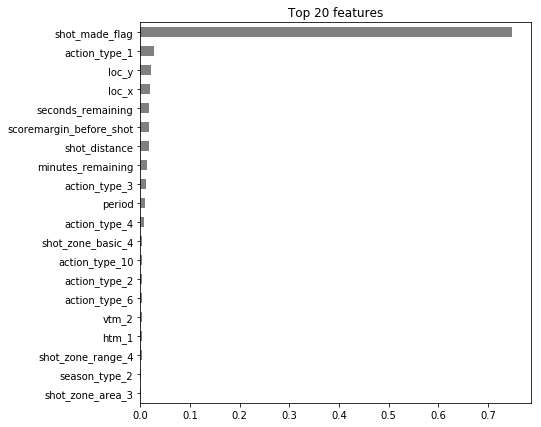

In [11]:
# Get feature importances
encoder = pipeline.named_steps['onehotencoder']
tree = pipeline.named_steps['randomforestclassifier']

feature_names = encoder.transform(X_val).columns

importances = pd.Series(tree.feature_importances_, feature_names)

# Plot feature importances
n = 20
plt.figure(figsize=(7,7))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [ ]:
pip install mlxtend

In [12]:
%matplotlib inline
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix

print(classification_report(y_val, y_pred))
confusion_matrix(y_val, y_pred)

#plt.figure(figsize=(10, 6))
#plot_decision_regions(X_val, y_val, y_pred, legend=0);

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       594
           1       1.00      1.00      1.00       565

   micro avg       1.00      1.00      1.00      1159
   macro avg       1.00      1.00      1.00      1159
weighted avg       1.00      1.00      1.00      1159



array([[594,   0],
       [  0, 565]])

In [13]:
#Calculate accuracy, precision, and recall for this confusion matrix:
true_negative = 85
false_negative = 8

true_positive = 36
false_positive = 58

total = 85 + 8 + 58 +36
#accuracy is the sum of correct predictions divided by total predictions
accuracy = (true_positive + true_negative) / (total)

#precision is class accuracy of actual results
pos_precision = true_positive / (true_positive + false_positive)
neg_precision = true_negative / (true_negative + false_negative)

#recall is class accuracy of predicted results
pos_recall = true_positive / (true_positive + false_negative)
neg_recall = true_negative / (true_negative + false_positive)

print(f'The accuracy of this model the table represents is {accuracy}')
print(f'The precision of the positive class is {pos_precision}')
print(f'The precision of the negative class is {neg_precision}')
print(f'The recall of the positive class is {pos_recall}')
print(f'The recall of the negative class is {neg_recall}')

The accuracy of this model the table represents is 0.6470588235294118
The precision of the positive class is 0.3829787234042553
The precision of the negative class is 0.9139784946236559
The recall of the positive class is 0.8181818181818182
The recall of the negative class is 0.5944055944055944


This Sprint Challenge has two parts. To demonstrate mastery on each part, do all the required, numbered instructions. To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.
2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?
3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?
    

## Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)
2. Get your model's **test accuracy.** (One time, at the end.)
3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**
4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>


### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.
- Plot a real confusion matrix for your basketball model, with row and column labels.
- Print the classification report for your model.